In [1]:
from __future__ import print_function

import tensorflow as tf
from tensorflow.contrib import rnn
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

#Import MNIST data
# from tensorflow.examples.tutorials.mnist import input_data

# mnist = input_data.read_data_sets('../Tensorflow Examples Models/mnist', one_hot=True)

from keras import backend as K

#Clear TF memory
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

C:\Users\StrikeWade\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class ToySequenceData(object):
    """ Generate sequence of data with dynamic length.
    This class generate samples for training:
    - Class 0: linear sequences (i.e. [0, 1, 2, 3,...])
    - Class 1: random sequences (i.e. [1, 3, 10, 7,...])

    NOTICE:
    We have to pad each sequence to reach 'max_seq_len' for TensorFlow
    consistency (we cannot feed a numpy array with inconsistent
    dimensions). The dynamic calculation will then be perform thanks to
    'seqlen' attribute that records every actual sequence length.
    """
    def __init__(self, n_samples=1000, max_seq_len=20, min_seq_len=3,
                 max_value=1000):
        self.data = []
        self.labels = []
        self.seqlen = []
        for i in range(n_samples):
            # Random sequence length
            len = random.randint(min_seq_len, max_seq_len)
            # Monitor sequence length for TensorFlow dynamic calculation
            self.seqlen.append(len)
            # Add a random or linear int sequence (50% prob)
            if random.random() < .5:
                # Generate a linear sequence
                rand_start = random.randint(0, max_value - len)
                s = [[float(i)/max_value] for i in
                     range(rand_start, rand_start + len)]
                # Pad sequence for dimension consistency
                s += [[0.] for i in range(max_seq_len - len)]
                self.data.append(s)
                self.labels.append([1., 0.])
            else:
                # Generate a random sequence
                s = [[float(random.randint(0, max_value))/max_value]
                     for i in range(len)]
                # Pad sequence for dimension consistency
                s += [[0.] for i in range(max_seq_len - len)]
                self.data.append(s)
                self.labels.append([0., 1.])
        self.batch_id = 0

    def next(self, batch_size):
        """ Return a batch of data. When dataset end is reached, start over.
        """
        if self.batch_id == len(self.data):
            self.batch_id = 0
        batch_data = (self.data[self.batch_id:min(self.batch_id +
                                                  batch_size, len(self.data))])
        batch_labels = (self.labels[self.batch_id:min(self.batch_id +
                                                  batch_size, len(self.data))])
        batch_seqlen = (self.seqlen[self.batch_id:min(self.batch_id +
                                                  batch_size, len(self.data))])
        self.batch_id = min(self.batch_id + batch_size, len(self.data))
        return batch_data, batch_labels, batch_seqlen

In [3]:
#Params
learning_rate = 0.01
training_steps = 10000
batch_size = 128
display_step = 200

#Network Params
seq_max_len = 20 #sequence max length
num_hidden = 64 #hidden layer num of features
num_classes = 2 #linear sequence or not

#TF graph input
x = tf.placeholder(dtype=tf.float32, shape=[None, seq_max_len, 1])
y = tf.placeholder(dtype=tf.float32, shape=[None, num_classes])

trainset = ToySequenceData(n_samples=1000, max_seq_len=seq_max_len)
testset = ToySequenceData(n_samples=500, max_seq_len=seq_max_len)

#A placeholder for indicating each sequence length
seqlen = tf.placeholder(dtype=tf.int32, shape=[None])

#Define weights and biases
weights = {
    'out': tf.Variable(tf.random_normal([num_hidden, num_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([num_classes]))
}

In [4]:
def DynamicRNN(x, seqlen, weights, biases):
    #Prepare data shape to match 'rnn' function requirements
    #Current data input shape: (batch_size, num_steps, num_input)
    #Required shape: 'num_steps' tensor list of shape (batch_size, num_input)
    
    #Unstack to get a list of 'num_steps' tensors of shape (batch_size, num_input)
    x = tf.unstack(x, seq_max_len, 1)
    print('\n    x after unstack: ', x, '\n')
    
    #Define a lstm cell with a tensorflow
    lstm_cell = tf.contrib.rnn.BasicLSTMCell(num_hidden)
    
    #Get lstm cell output, providing 'sequence_length' will perform dynamic calculation
    outputs, states = tf.contrib.rnn.static_rnn(lstm_cell, x, dtype=tf.float32, sequence_length=seqlen)
    print('\n    outputs and states: ', outputs, states, '\n')
    
    #When performing dynamic calculation, we must retrieve the last
    #dynamically computed output, i.e: if a sequence length is 10, we need to retrieve the 10th output
    #However TF doesnt support advanced indexing yet, so we build a custom op that for each sample in batch size
    #get its length and get the corresponding relevant ouput
    
    #'outputs' is a list of output at every timestep, we pack them in a tensor
    #and change back dimension to [batch_size, num_step, num_input]
    outputs = tf.stack(outputs)
    print('\n    outputs after stack: ',outputs, '\n')
    outputs = tf.transpose(outputs, [1,0,2])
    print('\n    outputs after transpose: ',outputs, '\n')
    
    #Hack to build the indexing and retrieve the right output
    batch_size = tf.shape(outputs)[0]
    print('\n    batchsize ???? : ', batch_size, '\n')
    
    #Start indices for each sample
    index = tf.range(0, batch_size) * seq_max_len + (seqlen-1)
    print('\n    index: ',index, '\n')
    #Indexing
    outputs = tf.gather(tf.reshape(outputs, shape=[-1, num_hidden]), index)
    print('\n    Output after gather: ', outputs, '\n')
    
    #Linear activation, using outputs computed above
    return tf.matmul(outputs, weights['out']) + biases['out']

In [5]:
prediction = DynamicRNN(x, seqlen, weights, biases)

#Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss_op)

#Evaluate model
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))

#Initialize the global var
init = tf.global_variables_initializer()


    x after unstack:  [<tf.Tensor 'unstack:0' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:1' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:2' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:3' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:4' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:5' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:6' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:7' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:8' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:9' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:10' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:11' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:12' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:13' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:14' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:15' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:16' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:17' shape=(?, 1) dtype=float32>, <tf.Tensor 'unstack:18' shape=(?

C:\Users\StrikeWade\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [6]:
#Start training
training_loss = []

with tf.Session() as sess:
    sess.run(init)
    
    for step in range(1, training_steps+1):
        batch_x, batch_y, batch_seqlen = trainset.next(batch_size)
        
        #Run optimization (backprop)
        sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, seqlen: batch_seqlen})
        
        if step % display_step == 0 or step == 1:
            #Calculate batch accuracy & loss
            acc, loss = sess.run([accuracy, loss_op], feed_dict={x: batch_x, y: batch_y, seqlen: batch_seqlen})
            
            training_loss.append(loss)
            
            print('Step: ', str(step), '\n    Minibatch Loss= {:.4f}'.format(loss), '\n    Training Accuracy= {:.3f}'.format(acc))
            
    print('DynamicRNN Training Completed !!!!')
    
    #Calculate accuracy
    test_data = testset.data
    test_label = testset.labels
    test_seqlen = testset.seqlen
    print('Testing Accuracy: ', sess.run(accuracy, feed_dict={x: test_data, y: test_label, seqlen: test_seqlen}))

Step:  1 
    Minibatch Loss= 0.8794 
    Training Accuracy= 0.539
Step:  200 
    Minibatch Loss= 0.6870 
    Training Accuracy= 0.558
Step:  400 
    Minibatch Loss= 0.6878 
    Training Accuracy= 0.529
Step:  600 
    Minibatch Loss= 0.6878 
    Training Accuracy= 0.548
Step:  800 
    Minibatch Loss= 0.6869 
    Training Accuracy= 0.538
Step:  1000 
    Minibatch Loss= 0.6853 
    Training Accuracy= 0.548
Step:  1200 
    Minibatch Loss= 0.6827 
    Training Accuracy= 0.577
Step:  1400 
    Minibatch Loss= 0.6781 
    Training Accuracy= 0.606
Step:  1600 
    Minibatch Loss= 0.6688 
    Training Accuracy= 0.625
Step:  1800 
    Minibatch Loss= 0.6442 
    Training Accuracy= 0.635
Step:  2000 
    Minibatch Loss= 0.5727 
    Training Accuracy= 0.731
Step:  2200 
    Minibatch Loss= 0.4972 
    Training Accuracy= 0.808
Step:  2400 
    Minibatch Loss= 0.4728 
    Training Accuracy= 0.827
Step:  2600 
    Minibatch Loss= 0.4635 
    Training Accuracy= 0.827
Step:  2800 
    Minibatch 

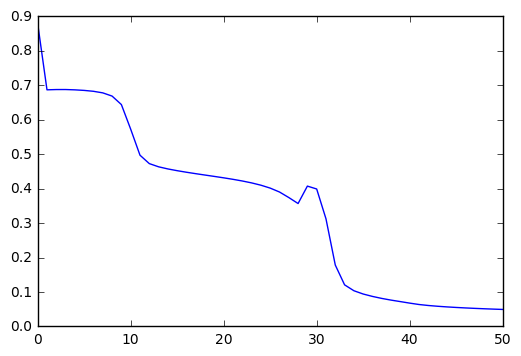

In [7]:
plt.plot(training_loss)
plt.show()